In [ ]:
!nvidia-smi

Thu Jan  2 09:48:54 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Download and Configure the model

In [ ]:
EXAMPLE_IMAGE_PATH = "/content/flir_7- photo.jpg"

In [ ]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [ ]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

Importing from timm.models.layers is deprecated, please import via timm.layers


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Inference using pretrained model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


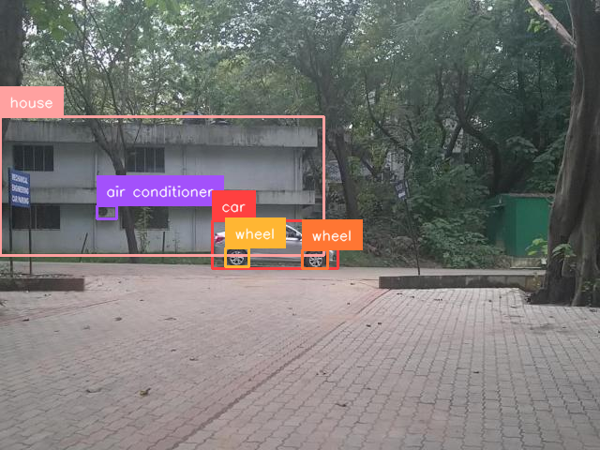

In [ ]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

Example image captioning inference

In [ ]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a car on the road. We can also see a board with some text on it, a group of trees, a building with windows, a signboard and the sky.'}

Download Dataset

In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"flir_1090-photo_jpg.rf.a862a1bafa36431d51a1b48c58ab52f9.jpg","prefix":"<OD>","suffix":"Vehicle4W<loc_34><loc_424><loc_550><loc_679>"}
{"image":"flir_2-photo_jpg.rf.a9b09628323d7b3354088f2b75e9e96f.jpg","prefix":"<OD>","suffix":"Vehicle4W<loc_0><loc_473><loc_136><loc_588>"}
{"image":"flir_1507-photo_jpg.rf.a7d48ea40965f565ad183c6ecf7ac68d.jpg","prefix":"<OD>","suffix":"Vehicle4W<loc_865><loc_378><loc_999><loc_506>"}
{"image":"flir_2107-photo_jpg.rf.a7301151ced4d86a63c23b9f8a62e34b.jpg","prefix":"<OD>","suffix":"Person<loc_443><loc_245><loc_546><loc_663>"}
{"image":"flir_17-photo_jpg.rf.a6f7e39c17d9515a92fe545bc9784286.jpg","prefix":"<OD>","suffix":"Vehicle4W<loc_0><loc_476><loc_177><loc_586>"}


Define `DetectionsDataset` class

In [ ]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

Initiate `DetectionsDataset` and `DataLoader`

In [ ]:
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

Setup LoRA Florence-2 model

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [ ]:
torch.cuda.empty_cache()

Run inference with pre-trained Florence-2 model on validation dataset

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



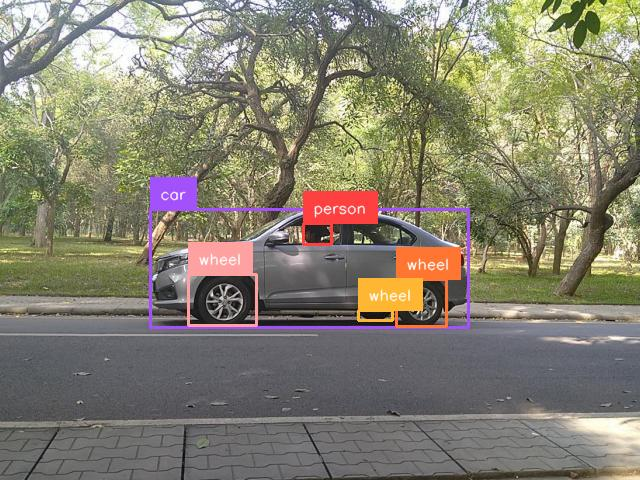
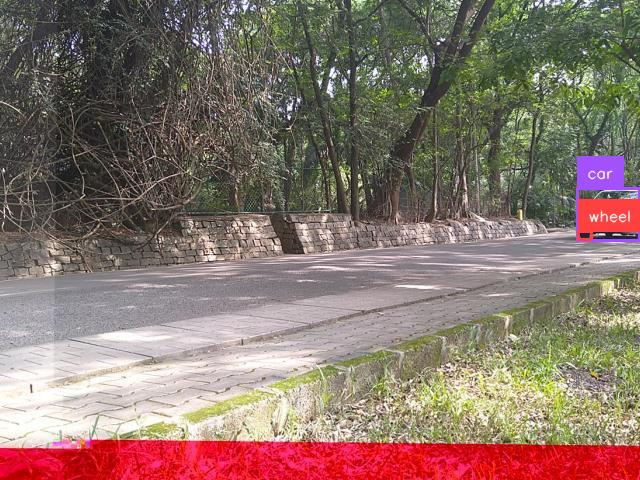
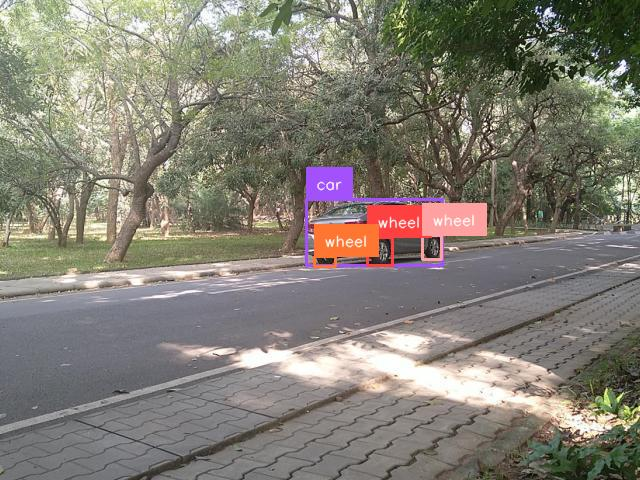
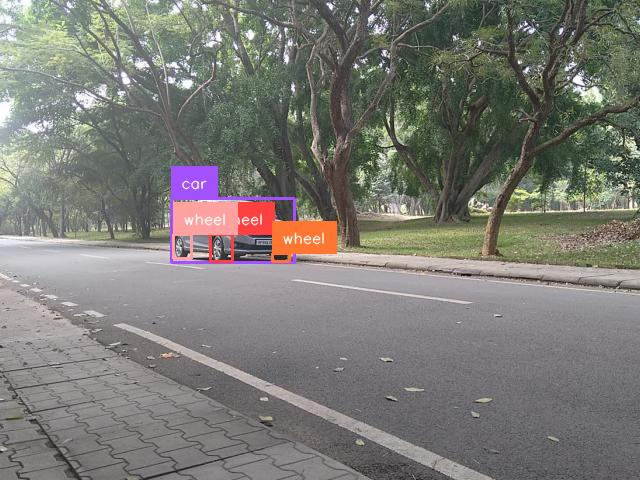

In [ ]:
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

Define train loop

In [ ]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

Run train loop

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to 


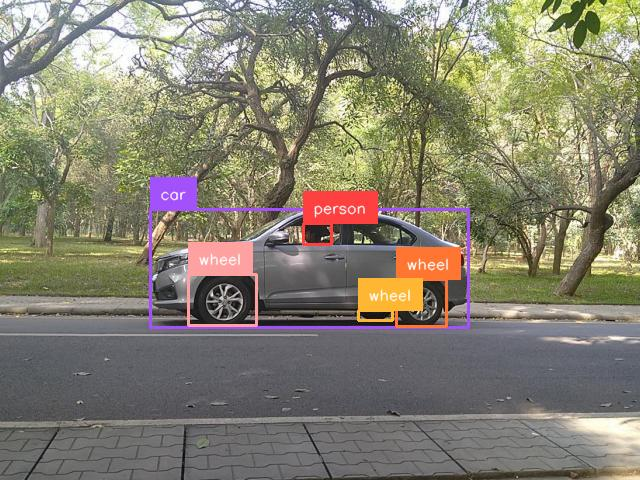
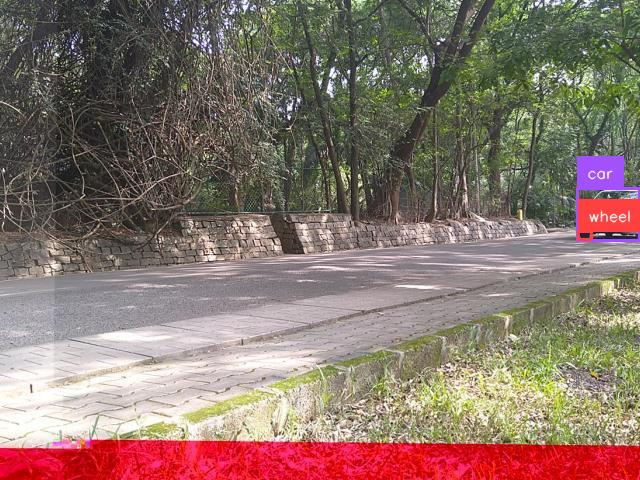
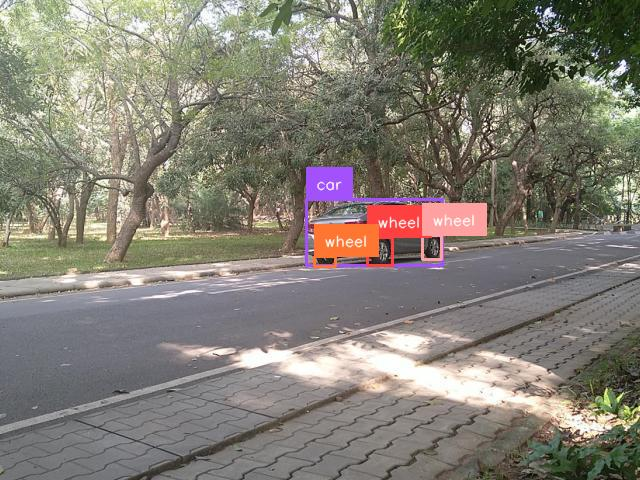
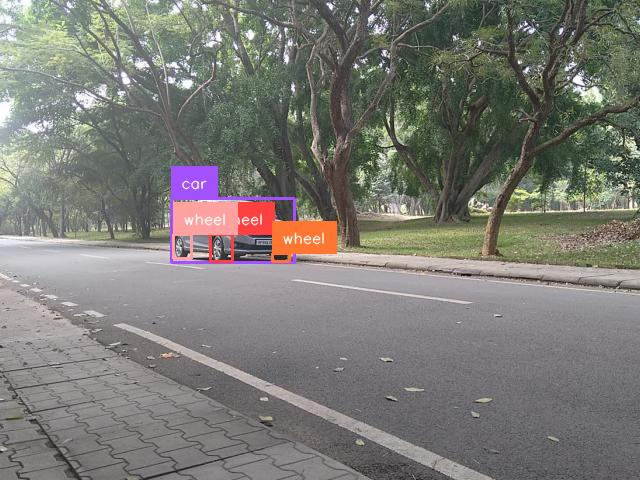
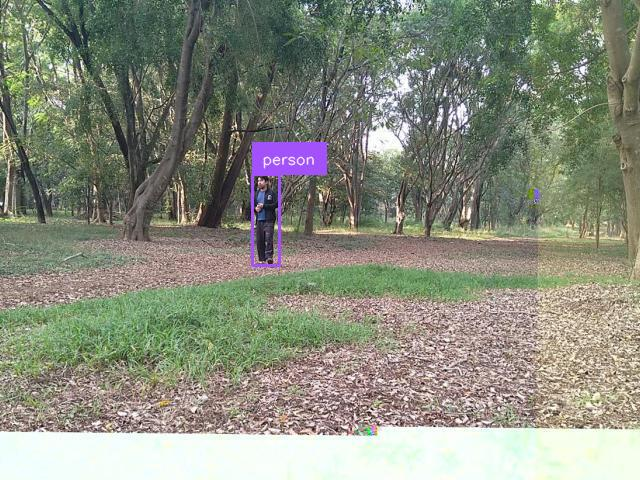
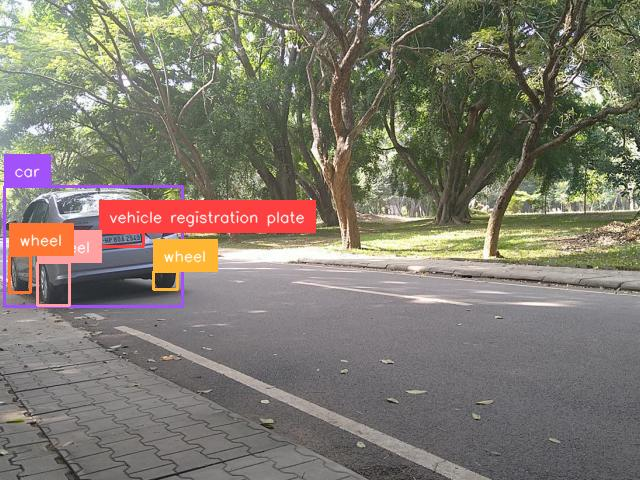

Training Epoch 1/5: 100%|██████████| 503/503 [14:17<00:00,  1.70s/it]


Average Training Loss: 1.0596719861149078


Validation Epoch 1/5: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]


Average Validation Loss: 0.97524218929225


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox


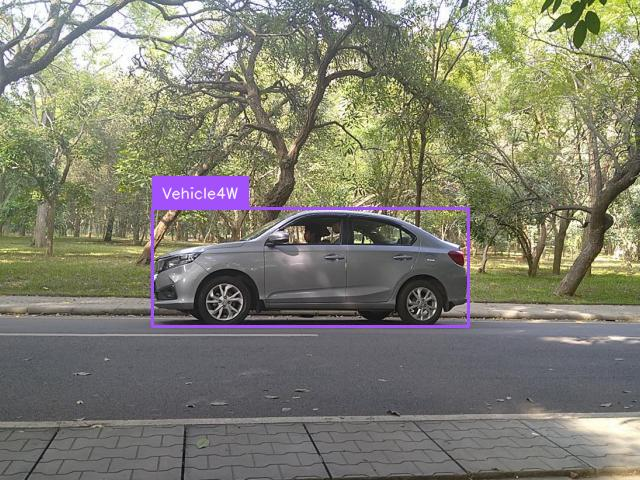
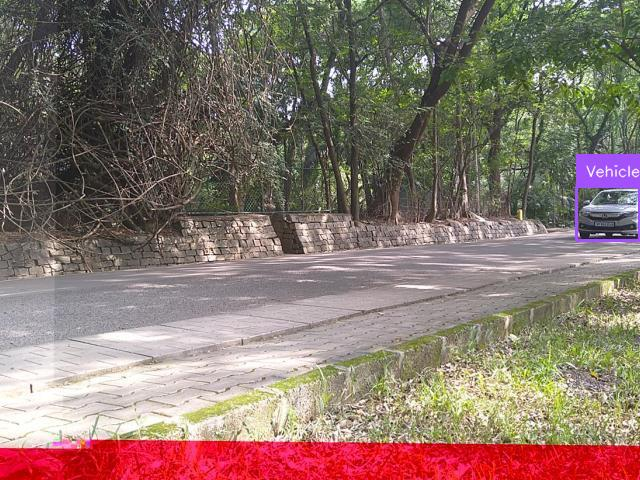
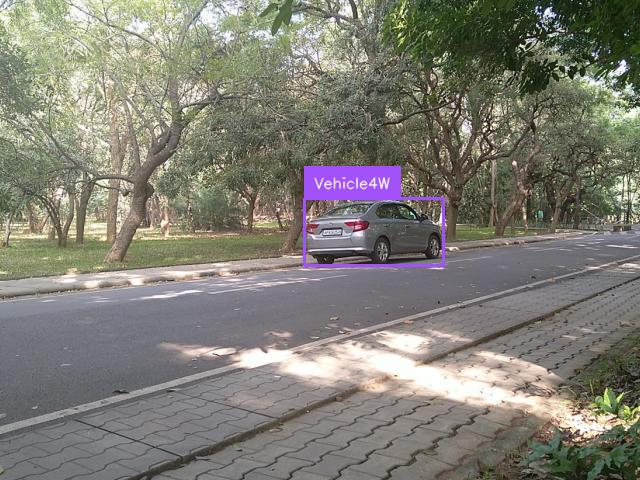
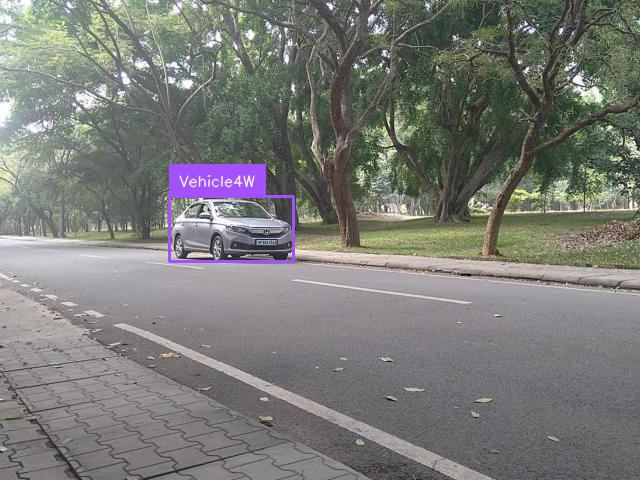
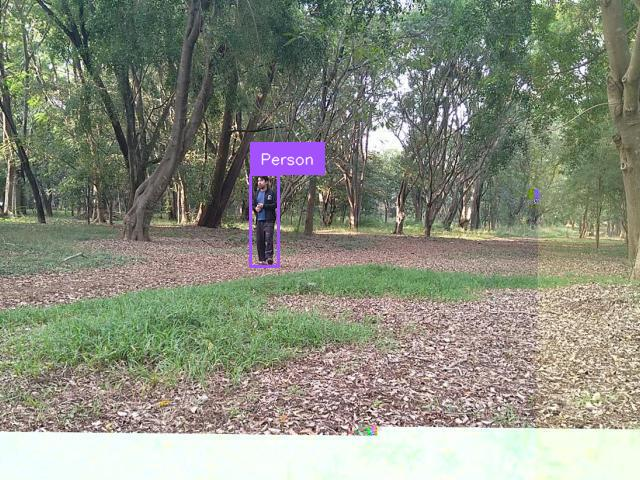
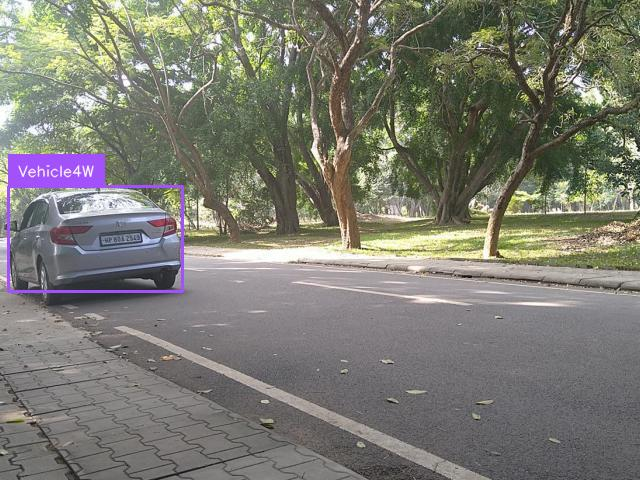

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/5: 100%|██████████| 503/503 [14:21<00:00,  1.71s/it]


Average Training Loss: 0.9721321877143966


Validation Epoch 2/5: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]


Average Validation Loss: 0.9175261509144443


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox


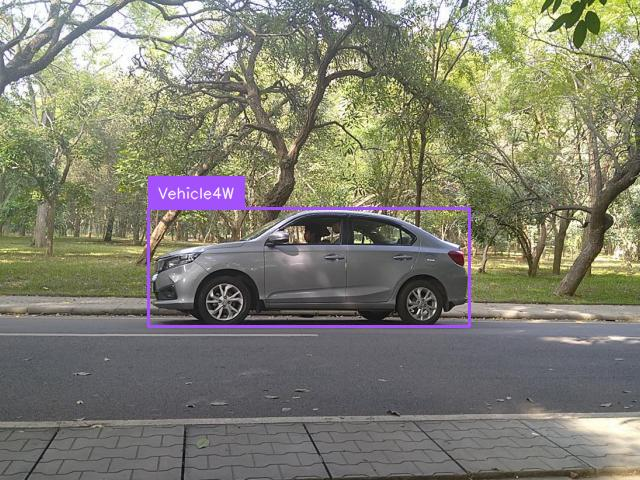
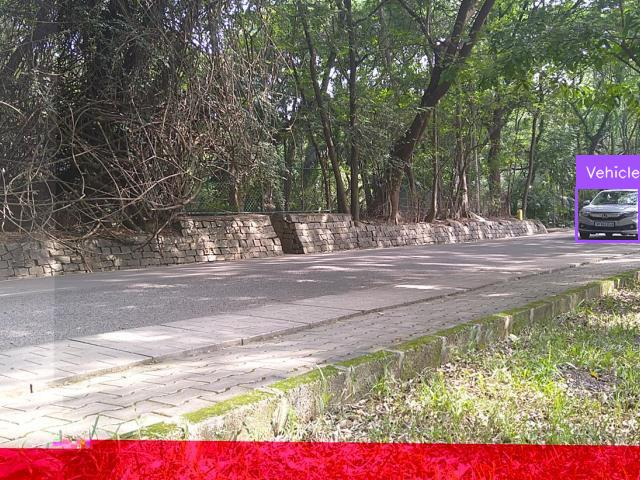
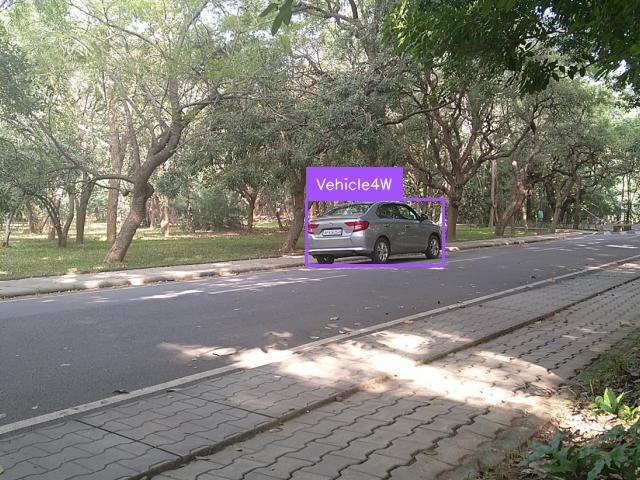
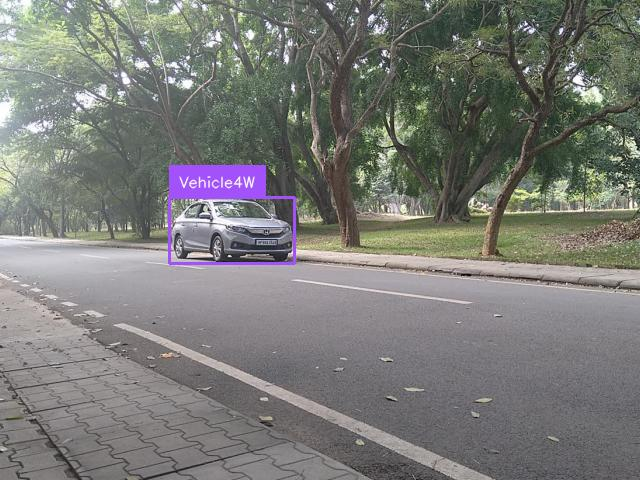
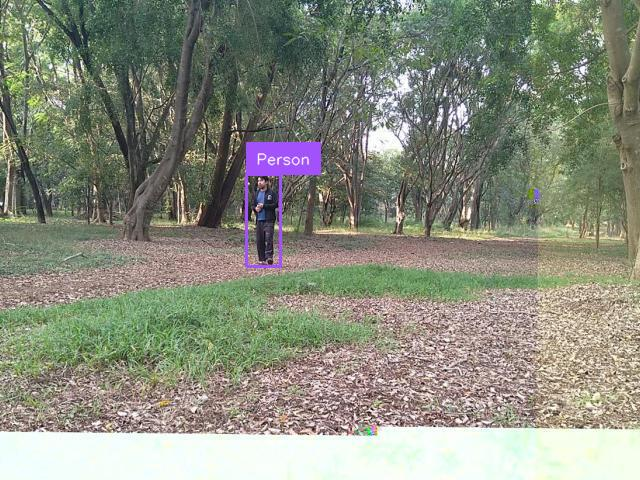
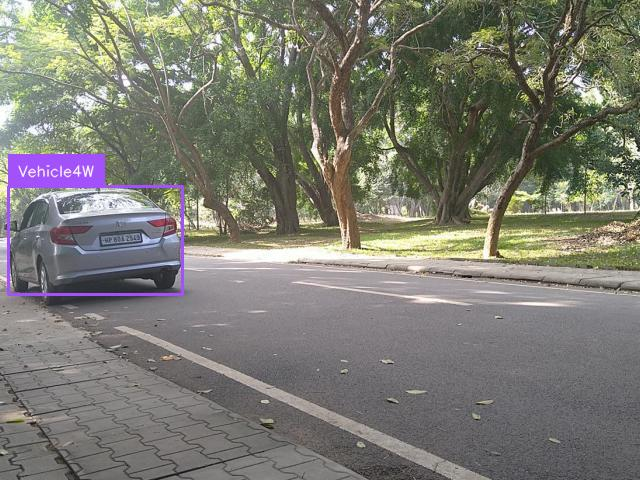

Training Epoch 3/5: 100%|██████████| 503/503 [14:21<00:00,  1.71s/it]


Average Training Loss: 0.9244459061096487


Validation Epoch 3/5: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]


Average Validation Loss: 0.9591562158759983


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox


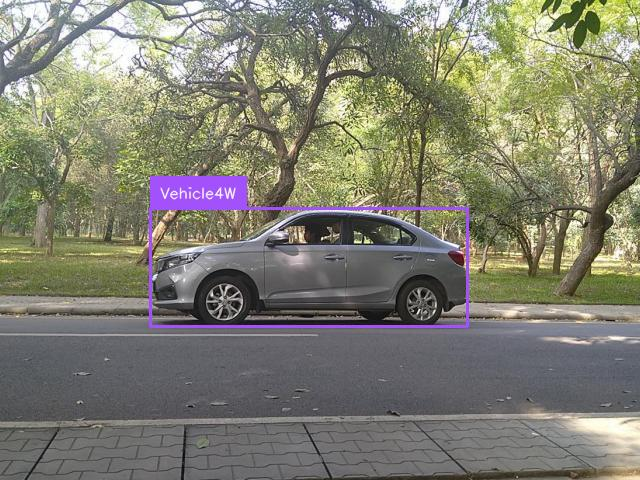
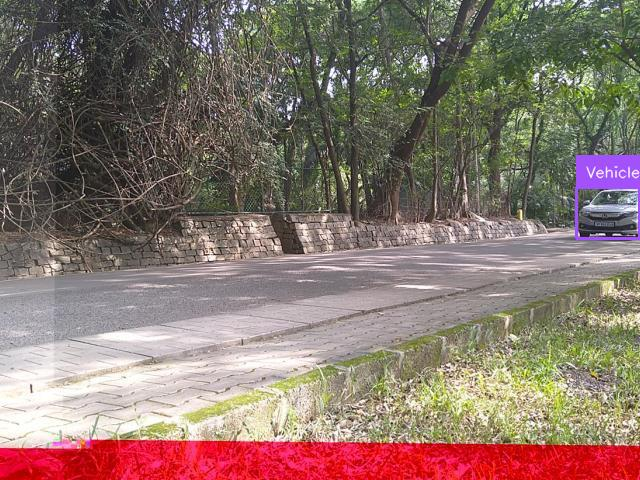
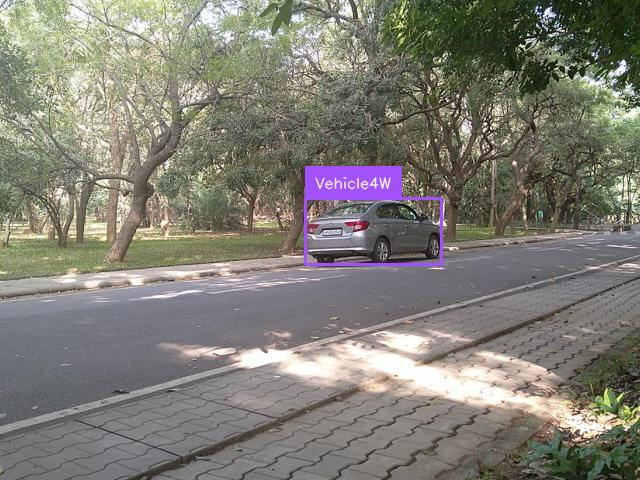
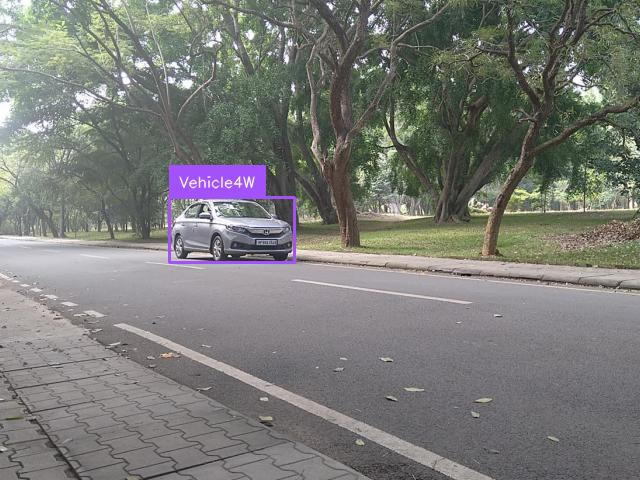
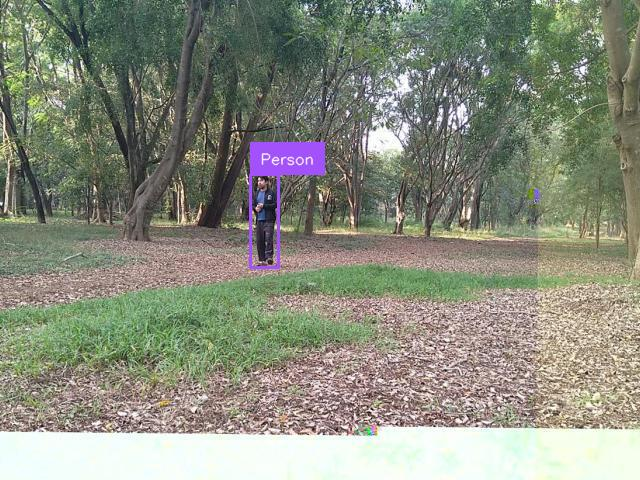
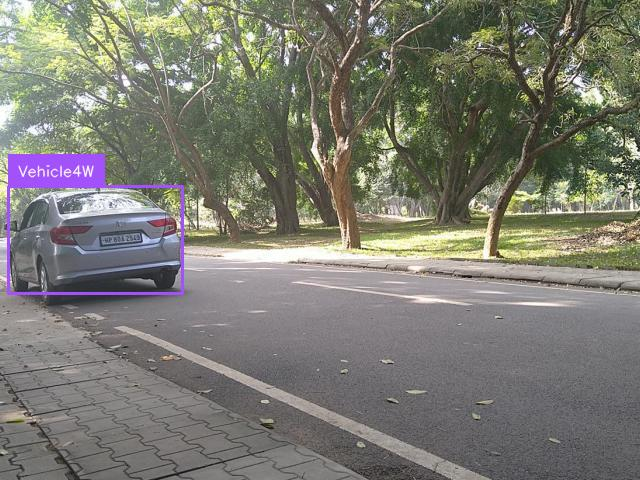

Training Epoch 4/5: 100%|██████████| 503/503 [14:22<00:00,  1.71s/it]


Average Training Loss: 0.8511344814158339


Validation Epoch 4/5: 100%|██████████| 87/87 [01:13<00:00,  1.18it/s]


Average Validation Loss: 0.8966843413895574


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox


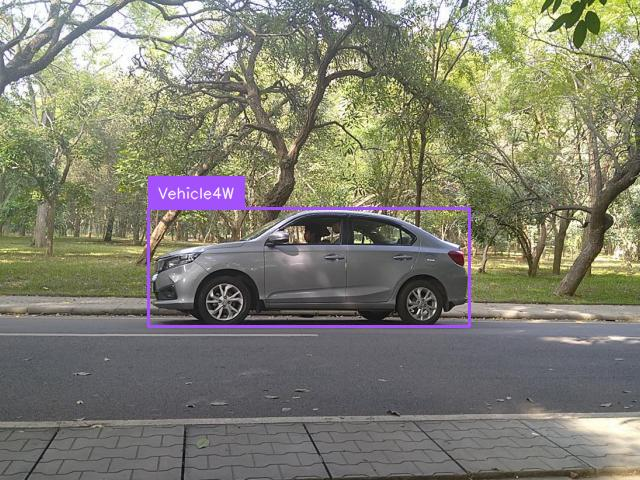
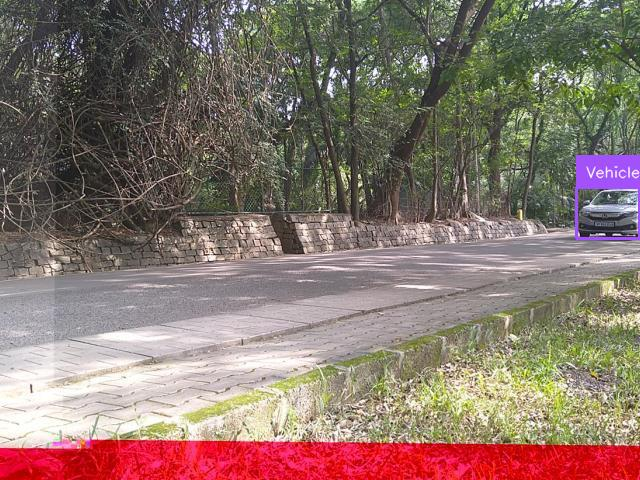
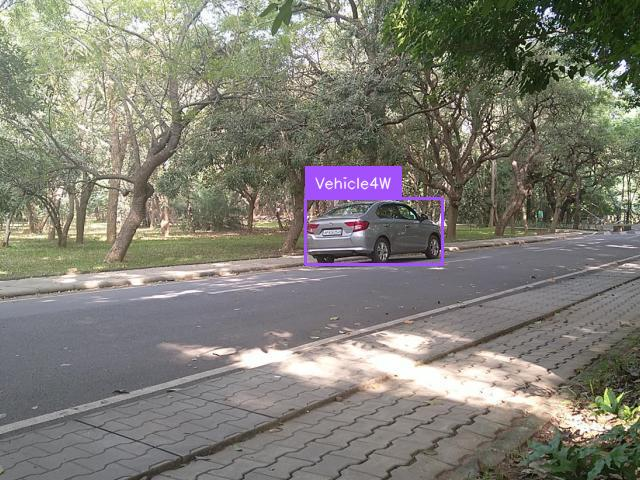
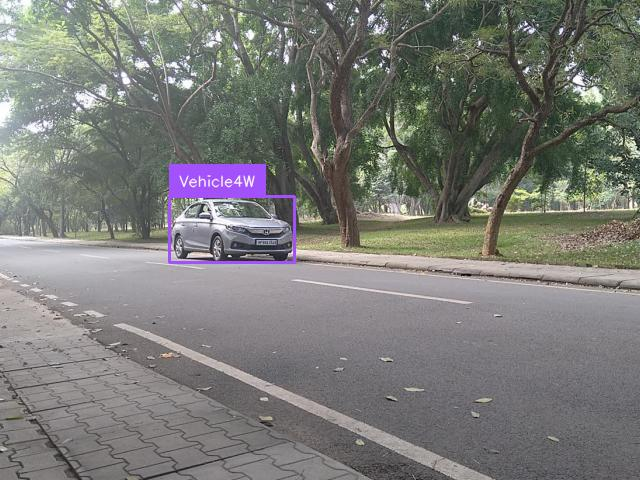
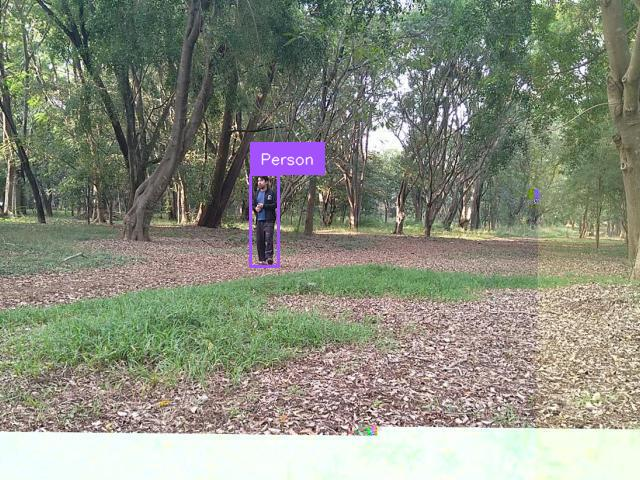
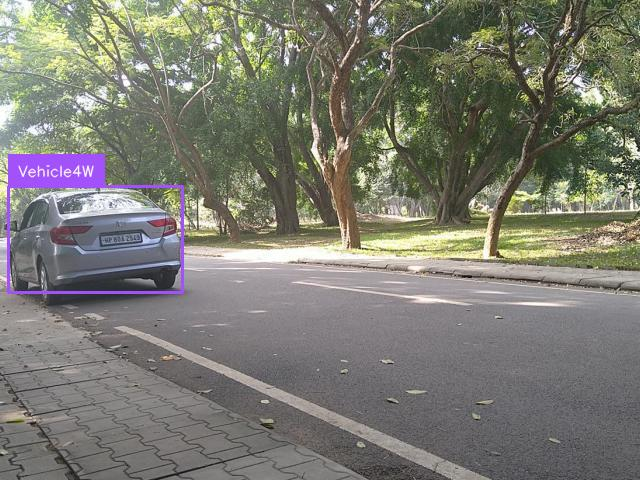

Training Epoch 5/5: 100%|██████████| 503/503 [14:27<00:00,  1.73s/it]


Average Training Loss: 0.7425846954285505


Validation Epoch 5/5: 100%|██████████| 87/87 [01:14<00:00,  1.17it/s]


Average Validation Loss: 0.9121642455287363


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox


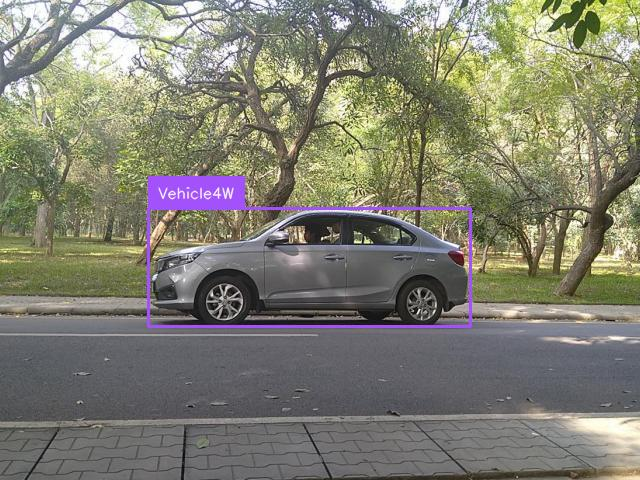
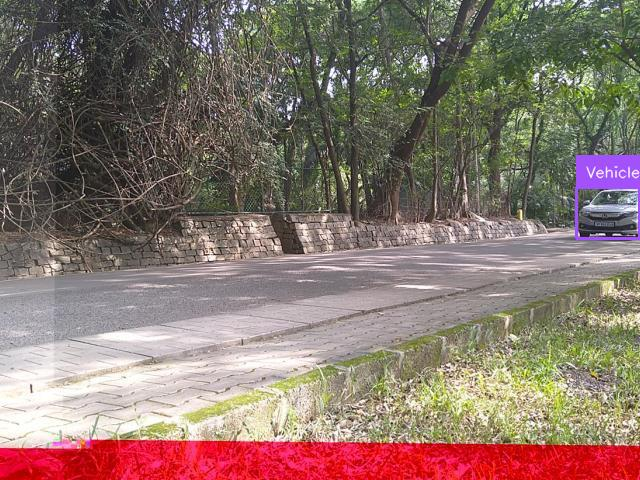
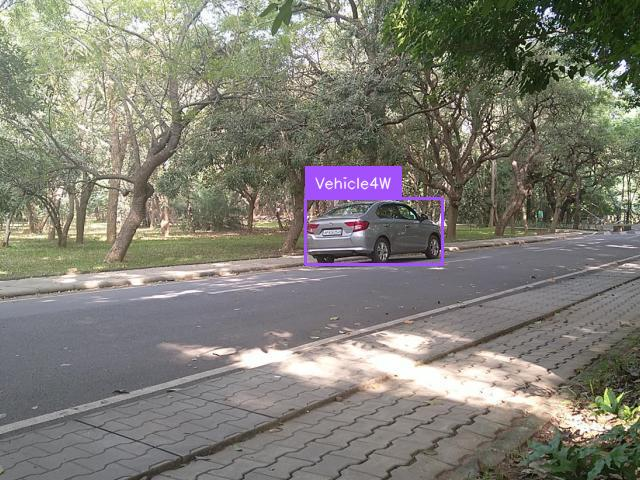
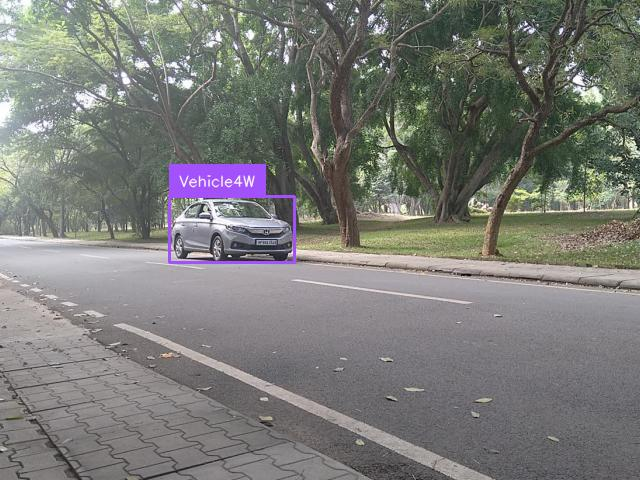
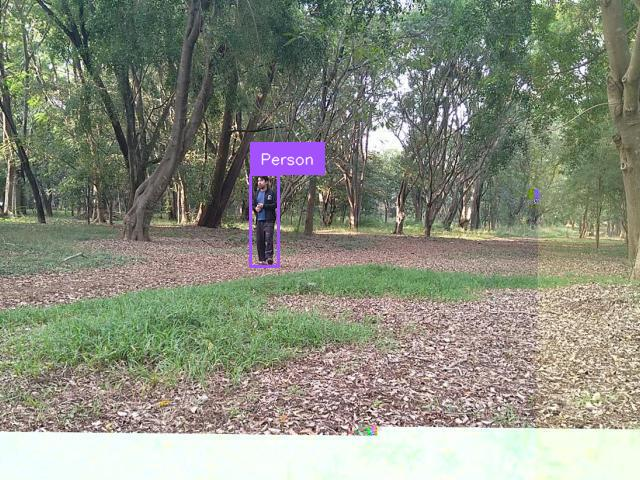
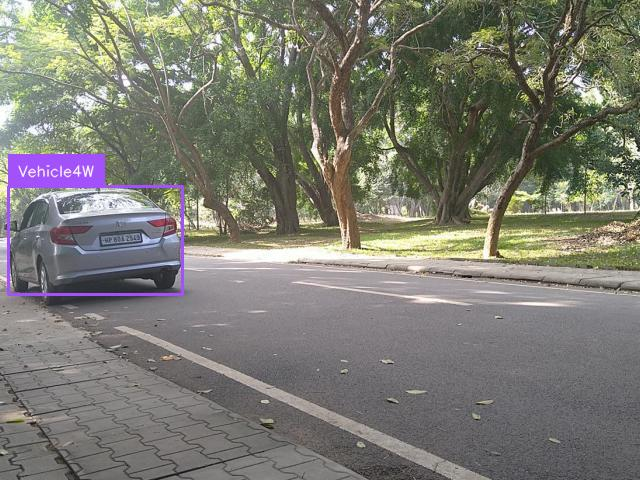

CPU times: user 58min 18s, sys: 19min 8s, total: 1h 17min 27s
Wall time: 1h 18min 17s


In [ ]:
%%time

EPOCHS = 5
LR = 5e-4

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

Check the model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


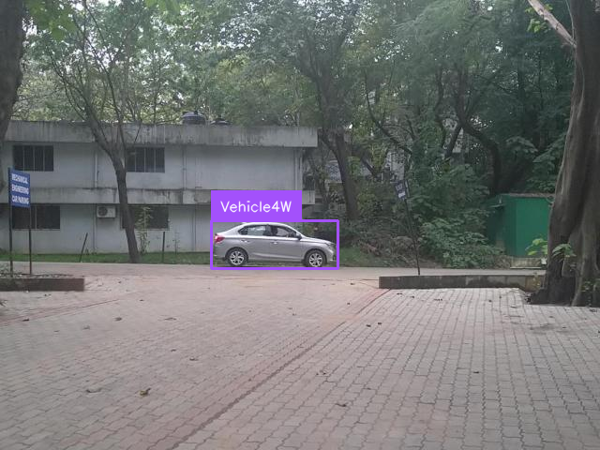

In [ ]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

Collect predictions

In [ ]:
PATTERN = r'([a-zA-Z0-9]+)<loc_\d+>'


def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)

NO_OBJ_CLASS = 'no_obj'  # Assign a name for the "no object" category
CLASSES.append(NO_OBJ_CLASS)  # Append 'no_obj' to the CLASSES list

# Create a mapping for class names to class IDs
class_name_to_id = {class_name: idx for idx, class_name in enumerate(CLASSES)}

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Generate prediction
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # If no predictions are detected, add a dummy detection for 'no_obj' class
    if len(prediction) > 0:
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
        prediction.class_id = np.array([class_name_to_id[class_name] for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))
    else:
        # Create a dummy detection with 'no_obj' class if no objects are detected
        prediction = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates
        prediction.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID
        prediction.confidence = np.ones(1)  # Default confidence for 'no_obj'

    # Process target (ground truth)
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)

    # If no target detections, add dummy target for 'no_obj'
    if len(target) > 0:
        target.class_id = np.array([class_name_to_id[class_name] for class_name in target['class_name']])
    else:
        target = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates for 'no_obj'
        target.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID

    # Append to predictions and targets lists
    targets.append(target)
    predictions.append(prediction)




calculate mAP

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.59
map50: 0.66
map75: 0.66


invalid value encountered in divide


Calculate Confusion Matrix

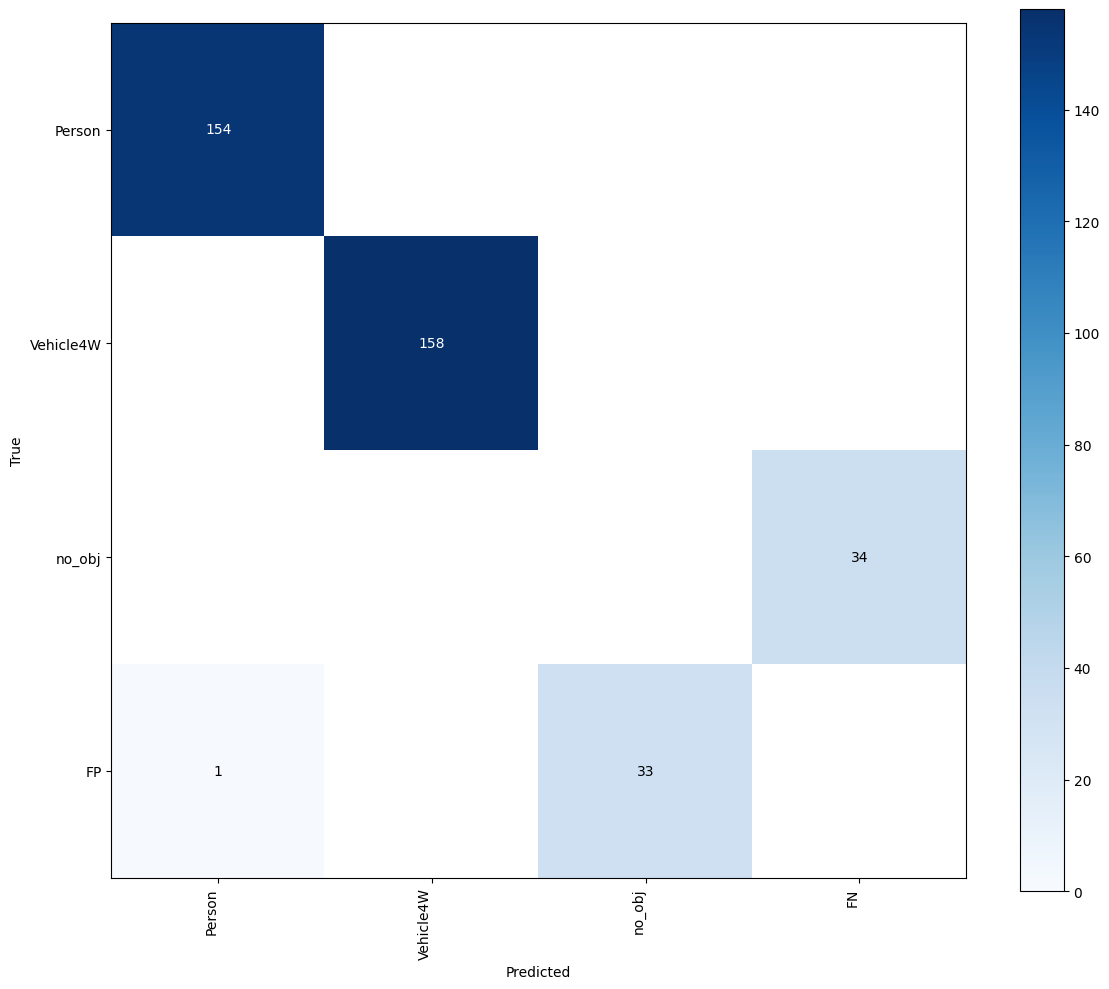

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

Collect Predictions

In [ ]:
CLASSES = ['Person', 'Vehicle4W']
NO_OBJ_CLASS = 'no_obj'  # Assign a name for the "no object" category
CLASSES.append(NO_OBJ_CLASS)  # Append 'no_obj' to the CLASSES list

# Create a mapping for class names to class IDs
class_name_to_id = {class_name: idx for idx, class_name in enumerate(CLASSES)}

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Generate prediction
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # If no predictions are detected, add a dummy detection for 'no_obj' class
    if len(prediction) > 0:
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
        prediction.class_id = np.array([class_name_to_id[class_name] for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))
    else:
        # Create a dummy detection with 'no_obj' class if no objects are detected
        prediction = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates
        prediction.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID
        prediction.confidence = np.ones(1)  # Default confidence for 'no_obj'

    # Process target (ground truth)
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)

    # If no target detections, add dummy target for 'no_obj'
    if len(target) > 0:
        target.class_id = np.array([class_name_to_id[class_name] for class_name in target['class_name']])
    else:
        target = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates for 'no_obj'
        target.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID

    # Append to predictions and targets lists
    targets.append(target)
    predictions.append(prediction)




calculate mAP

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

invalid value encountered in divide


map50_95: 0.59
map50: 0.66
map75: 0.66


Calculate Confusion Matrix

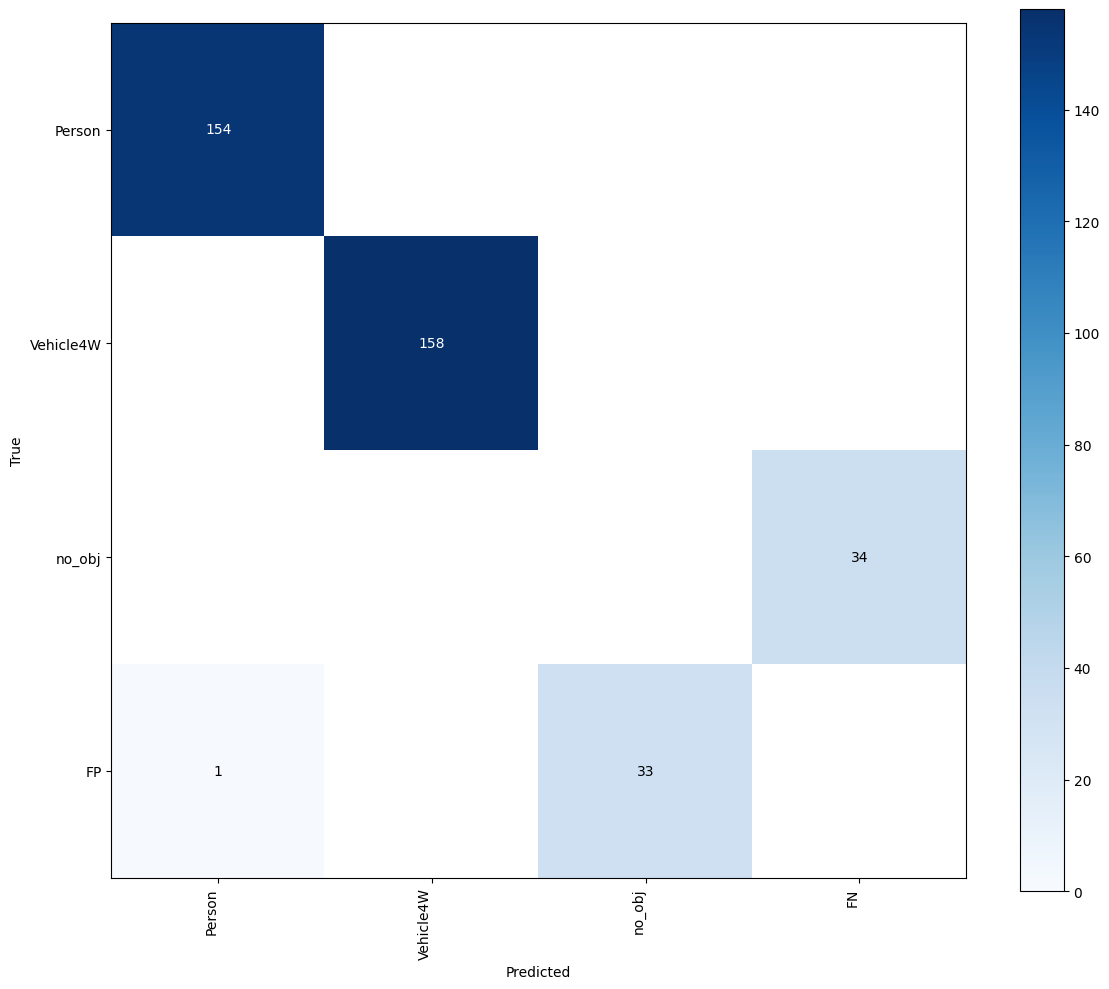

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

Test Data - Collecting Predictions

In [ ]:
CLASSES = ['Person', 'Vehicle4W']
NO_OBJ_CLASS = 'no_obj'  # Assign a name for the "no object" category
CLASSES.append(NO_OBJ_CLASS)  # Append 'no_obj' to the CLASSES list

# Create a mapping for class names to class IDs
class_name_to_id = {class_name: idx for idx, class_name in enumerate(CLASSES)}

targets = []
predictions = []

#  test dataset
for i in range(len(test_dataset.dataset)):  # Use test_dataset
    image, data = test_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Generate prediction
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # If no predictions are detected, add a dummy detection for 'no_obj' class
    if len(prediction) > 0:
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
        prediction.class_id = np.array([class_name_to_id[class_name] for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))
    else:
        # Create a dummy detection with 'no_obj' class if no objects are detected
        prediction = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates
        prediction.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID
        prediction.confidence = np.ones(1)  # Default confidence for 'no_obj'

    # Process target (ground truth)
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)

    # If no target detections, add dummy target for 'no_obj'
    if len(target) > 0:
        target.class_id = np.array([class_name_to_id[class_name] for class_name in target['class_name']])
    else:
        target = sv.Detections(xyxy=np.zeros((1, 4)))  # Dummy coordinates for 'no_obj'
        target.class_id = np.array([class_name_to_id[NO_OBJ_CLASS]])  # Assign 'no_obj' class ID

    # Append to predictions and targets lists
    targets.append(target)
    predictions.append(prediction)



calculate mAP

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.59
map50: 0.66
map75: 0.66


invalid value encountered in divide


Calculate Confusion Matrix

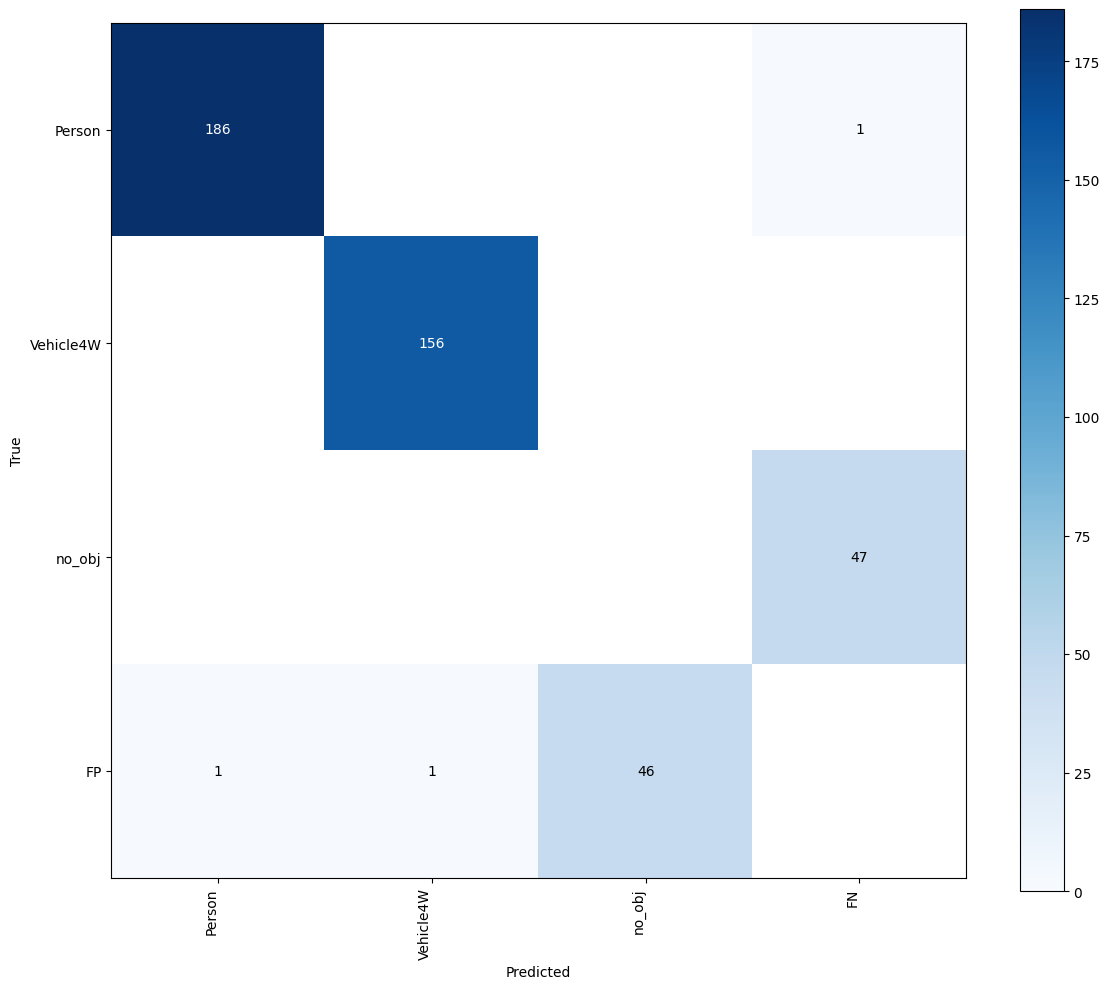

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [ ]:
peft_model.save_pretrained("/content/florence2-lora")
processor.save_pretrained("/content/florence2-lora/")
!ls -la /content/florence2-lora/

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


total 12848
drwxr-xr-x 2 root root    4096 Jan  2 12:52 .
drwxr-xr-x 1 root root    4096 Jan  2 12:52 ..
-rw-r--r-- 1 root root     817 Jan  2 12:52 adapter_config.json
-rw-r--r-- 1 root root 7747264 Jan  2 12:52 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Jan  2 12:52 added_tokens.json
-rw-r--r-- 1 root root  456318 Jan  2 12:52 merges.txt
-rw-r--r-- 1 root root     633 Jan  2 12:52 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Jan  2 12:52 README.md
-rw-r--r-- 1 root root  146627 Jan  2 12:52 special_tokens_map.json
-rw-r--r-- 1 root root  197689 Jan  2 12:52 tokenizer_config.json
-rw-r--r-- 1 root root 3747961 Jan  2 12:52 tokenizer.json
-rw-r--r-- 1 root root  798293 Jan  2 12:52 vocab.json


In [ ]:
!zip -r florence2_custom_rgb.zip florence2-lora/

  adding: florence2-lora/ (stored 0%)
  adding: florence2-lora/adapter_config.json (deflated 54%)
  adding: florence2-lora/tokenizer.json (deflated 83%)
  adding: florence2-lora/preprocessor_config.json (deflated 53%)
  adding: florence2-lora/README.md (deflated 66%)
  adding: florence2-lora/tokenizer_config.json (deflated 95%)
  adding: florence2-lora/merges.txt (deflated 53%)
  adding: florence2-lora/special_tokens_map.json (deflated 98%)
  adding: florence2-lora/vocab.json (deflated 59%)
  adding: florence2-lora/added_tokens.json (deflated 79%)
  adding: florence2-lora/adapter_model.safetensors (deflated 8%)


In [ ]:
from google.colab import files
files.download('florence2_custom_rgb.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r florence2_custom_rgb_cp.zip model_checkpoints/

  adding: model_checkpoints/ (stored 0%)
  adding: model_checkpoints/epoch_4/ (stored 0%)
  adding: model_checkpoints/epoch_4/adapter_config.json (deflated 54%)
  adding: model_checkpoints/epoch_4/tokenizer.json (deflated 83%)
  adding: model_checkpoints/epoch_4/preprocessor_config.json (deflated 53%)
  adding: model_checkpoints/epoch_4/README.md (deflated 66%)
  adding: model_checkpoints/epoch_4/tokenizer_config.json (deflated 95%)
  adding: model_checkpoints/epoch_4/merges.txt (deflated 53%)
  adding: model_checkpoints/epoch_4/special_tokens_map.json (deflated 98%)
  adding: model_checkpoints/epoch_4/vocab.json (deflated 59%)
  adding: model_checkpoints/epoch_4/added_tokens.json (deflated 79%)
  adding: model_checkpoints/epoch_4/adapter_model.safetensors (deflated 8%)
  adding: model_checkpoints/epoch_2/ (stored 0%)
  adding: model_checkpoints/epoch_2/adapter_config.json (deflated 54%)
  adding: model_checkpoints/epoch_2/tokenizer.json (deflated 83%)
  adding: model_checkpoints/epoch

In [ ]:
from google.colab import files
files.download('florence2_custom_rgb_cp.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>